## Price Prediction using XGBoost

# Build a model

` Notes`

- ` Using XGBoost; Random FOrest, LightGBM `
- ` Explore CrossValidation apart from sklearn.cross_validation ` 
- `OneHotEncoding vs LabelEcoder`


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.grid_search import GridSearchCV

import os
# Transforming categorical features for train data
lbl = preprocessing.LabelEncoder()
enc = preprocessing.OneHotEncoder()
#models
import xgboost as xgb

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

% matplotlib inline


C:\Continuum\Anaconda3\envs\tf_cpu\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Continuum\Anaconda3\envs\tf_cpu\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
from datetime import datetime
from os.path import getmtime

IN_DIR = 'input/'
for filename in os.listdir(IN_DIR):
    print (filename,'\t' ,datetime.fromtimestamp(getmtime(os.path.join(IN_DIR, filename))).strftime('%m/%d/%Y\t%H%M'))

BAD_ADDRESS_FIX.xlsx 	 07/16/2017	2305
data_dictionary.txt 	 07/06/2017	2220
macro.csv 	 07/06/2017	2220
sample_submission.csv 	 04/11/2017	0948
test.csv 	 07/28/2017	2051
test_clean.csv 	 07/28/2017	2052
test_csv.zip 	 07/28/2017	2048
test_fe.csv 	 07/30/2017	2035
train.csv 	 07/28/2017	2052
train_clean.csv 	 07/28/2017	2053
train_csv.zip 	 07/28/2017	2048
train_fe.csv 	 07/30/2017	2035


In [3]:
#import feature engineered data

train_df = pd.read_csv("input/train_fe.csv")
test_df = pd.read_csv("input/test_fe.csv")


In [4]:
# Data preprocessing and creating of test-train split of TRAIN DATA

for col in train_df.columns:
    if train_df[col].dtype == 'object':
        lbl.fit(train_df[col].values)
        train_df[col] = lbl.transform(train_df[col].values)
  #  else:
       # train_df[col] = train_df[col]
        
# Training data test-train set preparation 
train_y = train_df['price_doc']
train_X = train_df.drop(['id', 'timestamp','price_doc'],axis=1)

In [5]:
# Data preprocessing and creating of test-train split of TEST DATA
id_test = test_df['id']
#Preparing test data
for col in test_df.columns:
    if test_df[col].dtype == 'object':
        
        lbl.fit(test_df[col].values)
        test_df[col] = lbl.transform(test_df[col].values)
   # else:
        #test_df[col] = test_df[col]
            
        
test_X = test_df.drop(['id', 'timestamp'], axis=1)

#Show the results 
print("Test data set has {} samples".format(test_X.shape))   

Test data set has (7662, 396) samples


## Basic XGBOOST Model

In [6]:
print( train_X.shape, train_y.shape)

(30119, 396) (30119,)


In [7]:
dtrain = xgb.DMatrix(train_X, train_df['price_doc'])

** Using basic list of parameters for the initial setup **

In [8]:

xgb_params = {
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'silent': 0,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'max_depth': 5,
    'min_child_weight': 3
}

In [9]:
xgb_base_cv1 = xgb.cv(xgb_params, dtrain, num_boost_round=50, nfold=3, seed=0, 
                 feval= None,
                 maximize=False, early_stopping_rounds=10)

print('Cross Validation Score:' ,xgb_base_cv1.iloc[-1,:]['test-rmse-mean'])

xgb_base_cv1.describe()

Cross Validation Score: 2300743.41667


,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
count,5.000000e+01,50.000000,5.000000e+01,50.000000
mean,3.051732e+06,22903.817838,2.913831e+06,11546.560580
std,1.224685e+06,9315.735298,1.290327e+06,4032.687016
min,2.300743e+06,14095.291309,2.051494e+06,593.999404
25%,2.333432e+06,15574.899052,2.126301e+06,9605.070231
50%,2.440364e+06,19126.535357,2.290301e+06,11523.609066
75%,3.150803e+06,27774.176691,3.082511e+06,13607.040662
max,7.249912e+06,47576.134618,7.246858e+06,22164.418972


      The crossvalidation score of for the test set 2.300743e+06 can be starting score. Now to scale the tuning, the seeing 
      how train error and test error vary gives a better insight. 

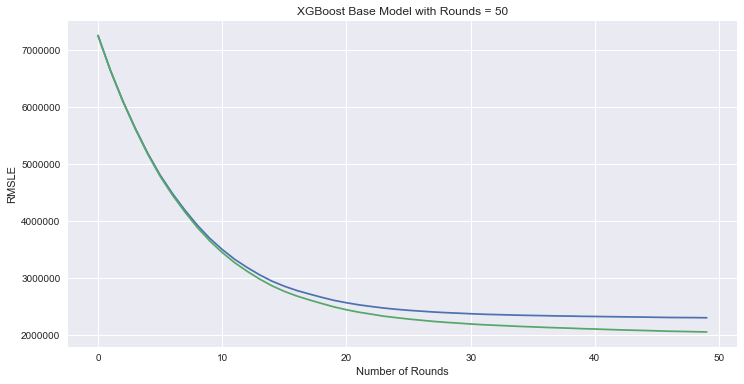

In [10]:
fig,ax =  plt.subplots(figsize= (12,6))

ax.set_title('XGBoost Base Model with Rounds = 50')
ax.plot(xgb_base_cv1[['test-rmse-mean', 'train-rmse-mean']])
ax.set_ylabel('RMSLE')
ax.set_xlabel('Number of Rounds')

plt.show()

Observing the XGBoost curves follwing infernce can be derived:

- Train and test curves are close hence there is not much overfitting
- Error is decreasing, so we can use more iterations.

This encourages us to use more number of rounds for 50 to say, 100.

In [11]:
xgb_base_cv2 = xgb.cv(xgb_params, dtrain, num_boost_round=100, nfold=3, seed=0, 
                 feval= None,
                 maximize=False, early_stopping_rounds=10)

print('Cross Validation Score:' ,xgb_base_cv2.iloc[-1,:]['test-rmse-mean'])

xgb_base_cv2.describe()

Cross Validation Score: 2250772.0


,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
count,1.000000e+02,100.000000,1.000000e+02,100.000000
mean,2.660826e+06,17723.451841,2.436307e+06,9718.864325
std,9.469955e+05,8439.464429,1.027380e+06,4092.677123
min,2.250772e+06,9513.172613,1.887246e+06,593.999404
25%,2.266469e+06,12941.521619,1.953791e+06,5871.072715
50%,2.300073e+06,14536.240760,2.049201e+06,10129.226212
75%,2.435867e+06,18920.728437,2.284208e+06,12648.221367
max,7.249912e+06,47576.134618,7.246858e+06,22164.418972


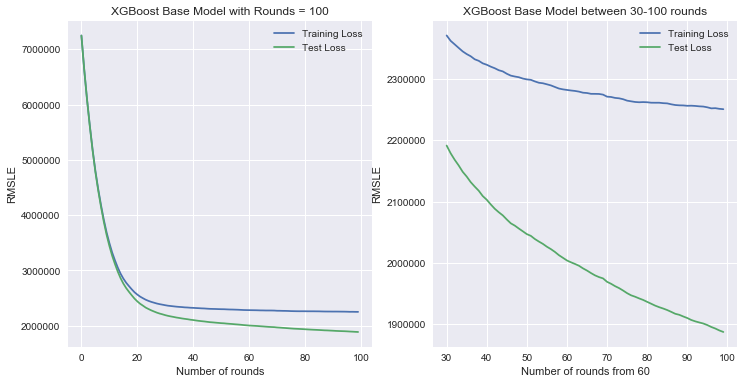

In [12]:
fig,(ax1,ax2) =  plt.subplots(figsize= (12,6), ncols=2)

ax1.set_title('XGBoost Base Model with Rounds = 100')
ax1.plot(xgb_base_cv2[['test-rmse-mean', 'train-rmse-mean']])
ax1.set_ylabel('RMSLE')
ax1.set_xlabel('Number of rounds')
ax1.legend(['Training Loss', 'Test Loss'])

ax2.set_title('XGBoost Base Model between 30-100 rounds')
ax2.plot(xgb_base_cv2.iloc[30:,][['test-rmse-mean', 'train-rmse-mean']])
ax2.set_ylabel('RMSLE')
ax2.set_xlabel('Number of rounds from 60')
ax2.legend(['Training Loss', 'Test Loss'])

plt.show()

On observing the second training data, 

The train-RMSLE is reducing from 2.051494e+06 to 1.887246e+06 whereas test-RMSLE from 2.300743e+06 to 2.051494e+06.

We can clearlysee that the model is getting overfitted as there is very less improvement in the test set. Hence it is better to stop at 50 and improve other important hyper parameters.




# XGBoost parameter tuning 

- max_depth
- min_child_wt
- gammma
- subsample
- col_sample_bytree 



### Scorer 

For the evaluation of grid search cross calidation, we define our own scoring function.

https://stats.stackexchange.com/questions/110599/how-to-get-both-mse-and-r2-from-a-sklearn-gridsearchcv

In [13]:
def fun_rmse(y_true,dtrain):
    labels = dtrain.get_label()
    rmse = (abs(mean_squared_error(y_true=y_true,y_pred=labels)))**0.5
    return rmse
def rmse_scorer():
    return make_scorer(fun_rmse, greater_is_better=False)    

### Note:

Unfortunaltey, I am unable to get the custom scorer into the GridSearchCV,so I am planning to use sklearn built-in scorer "mean square error" and then calculate square root to get root mean square.

In [14]:
def mse2rmse(score):
    for index,_ in enumerate(score):
        val_sq = (abs(score[index][1]))**0.5
        print ('rmse: {}'.format(val_sq), 'params: {}'.format(score[index][0]))

Validate the work around approach for scoring

In [15]:
xgb_params_cv = {'max_depth': [5], 'min_child_weight': [3]}

xgb_params = {
                 'colsample_bytree': 0.5,
                 'eta': 0.1,
                 'eval_metric': 'rmse',
                 'objective': 'reg:linear',
                 'seed': 0,
                 'silent': 0,
                 'subsample': 0.5
             }

In [16]:
valid_xgb = GridSearchCV(estimator=xgb.XGBRegressor(**xgb_params), param_grid=xgb_params_cv,scoring='mean_squared_error',
                                 cv = 5, n_jobs = -1)

In [17]:
%%time

valid_xgb.fit(train_X,train_y)

Wall time: 2min 28s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, eta=0.1, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=0, subsample=0.5),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [5], 'min_child_weight': [3]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [18]:
valid_xgb.grid_scores_

[mean: -5372357997112.13770, std: 620944936746.31836, params: {'min_child_weight': 3, 'max_depth': 5}]

In [19]:
mse2rmse( valid_xgb.grid_scores_)

rmse: 2317834.7648424245 params: {'min_child_weight': 3, 'max_depth': 5}


The value of rmse calculated is close to the rmse value derived from XGBoost "eval-metric"

### Step2: Tuning max_depth and min_child_weight

In [40]:
xgb_params_cv_1 = {'max_depth': list(range(4,10)), 'min_child_weight': list(range(1,7))}

In [41]:
xgb_params_1 = {
                 'colsample_bytree': 0.5,
                 'eta': 0.1,
                 'eval_metric': 'rmse',
                 
                 'objective': 'reg:linear',
                 'seed': 0,
                 'silent': 0,
                 'subsample': 0.5
             }

In [42]:
optimzed_xgb = GridSearchCV(estimator=xgb.XGBRegressor(**xgb_params_1), param_grid=xgb_params_cv_1,scoring='mean_squared_error',
                                cv = 5, n_jobs = -1)

In [43]:
%%time
optimzed_xgb.fit(train_X,train_y)

Wall time: 16min 55s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, eta=0.1, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=0, subsample=0.5),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [4, 5, 6, 7, 8, 9], 'min_child_weight': [1, 2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [44]:
(optimzed_xgb.grid_scores_)

[mean: -5473646542927.93066, std: 593610176470.56055, params: {'min_child_weight': 1, 'max_depth': 4},
 mean: -5493954973577.43262, std: 601532602548.58582, params: {'max_depth': 4, 'min_child_weight': 2},
 mean: -5491945959344.80469, std: 581801636910.26086, params: {'min_child_weight': 3, 'max_depth': 4},
 mean: -5486502247905.78809, std: 581665380117.24548, params: {'min_child_weight': 4, 'max_depth': 4},
 mean: -5449826807524.43359, std: 582486267747.24915, params: {'max_depth': 4, 'min_child_weight': 5},
 mean: -5449684969095.94141, std: 585494869897.47729, params: {'min_child_weight': 6, 'max_depth': 4},
 mean: -5358614367445.23145, std: 584771362907.82922, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: -5373511589510.83301, std: 593154905422.76770, params: {'max_depth': 5, 'min_child_weight': 2},
 mean: -5372357997112.13770, std: 620944936746.31836, params: {'min_child_weight': 3, 'max_depth': 5},
 mean: -5344816535622.92676, std: 622477341291.26196, params: {'max_depth

In [45]:
mse2rmse(optimzed_xgb.grid_scores_)

rmse: 2339582.557408037 params: {'min_child_weight': 1, 'max_depth': 4}
rmse: 2343918.721623562 params: {'max_depth': 4, 'min_child_weight': 2}
rmse: 2343490.1235859315 params: {'min_child_weight': 3, 'max_depth': 4}
rmse: 2342328.3817402264 params: {'min_child_weight': 4, 'max_depth': 4}
rmse: 2334486.4119382733 params: {'max_depth': 4, 'min_child_weight': 5}
rmse: 2334456.0328042037 params: {'min_child_weight': 6, 'max_depth': 4}
rmse: 2314868.1101620523 params: {'max_depth': 5, 'min_child_weight': 1}
rmse: 2318083.6027871887 params: {'max_depth': 5, 'min_child_weight': 2}
rmse: 2317834.7648424245 params: {'min_child_weight': 3, 'max_depth': 5}
rmse: 2311885.9261700017 params: {'max_depth': 5, 'min_child_weight': 4}
rmse: 2313059.039050395 params: {'min_child_weight': 5, 'max_depth': 5}
rmse: 2313652.8351194835 params: {'min_child_weight': 6, 'max_depth': 5}
rmse: 2311197.0238596406 params: {'max_depth': 6, 'min_child_weight': 1}
rmse: 2303408.4587797318 params: {'max_depth': 6, 'min

In [47]:
print([{'rmse' : (abs(optimzed_xgb.best_score_)**0.5)}, optimzed_xgb.best_params_])

[{'rmse': 2296285.6820142753}, {'min_child_weight': 5, 'max_depth': 6}]


In [48]:
def convert_grid_scores(scores):
    _params = []
    _params_mae = []    
    for i in scores:
        _params.append(i[0].values())
        _params_mae.append(i[1])
    params = np.array(_params)
    grid_res = np.column_stack((_params,_params_mae))
    return [grid_res[:,i] for i in range(grid_res.shape[1])]

In [49]:
convert_grid_scores(optimzed_xgb.grid_scores_)

[array([dict_values([1, 4]), dict_values([4, 2]), dict_values([3, 4]),
        dict_values([4, 4]), dict_values([4, 5]), dict_values([6, 4]),
        dict_values([5, 1]), dict_values([5, 2]), dict_values([3, 5]),
        dict_values([5, 4]), dict_values([5, 5]), dict_values([6, 5]),
        dict_values([6, 1]), dict_values([6, 2]), dict_values([3, 6]),
        dict_values([6, 4]), dict_values([5, 6]), dict_values([6, 6]),
        dict_values([7, 1]), dict_values([7, 2]), dict_values([7, 3]),
        dict_values([7, 4]), dict_values([5, 7]), dict_values([7, 6]),
        dict_values([1, 8]), dict_values([8, 2]), dict_values([3, 8]),
        dict_values([8, 4]), dict_values([8, 5]), dict_values([8, 6]),
        dict_values([1, 9]), dict_values([9, 2]), dict_values([9, 3]),
        dict_values([9, 4]), dict_values([5, 9]), dict_values([9, 6])], dtype=object),
 array([-5473646542927.931, -5493954973577.433, -5491945959344.805,
        -5486502247905.788, -5449826807524.434, -5449684969095.9

In [51]:
_, scores_1 = convert_grid_scores(optimzed_xgb.grid_scores_)
scores_1 = scores_1.reshape(6,6)
scores_1 = (abs(scores_1))**0.5

In [52]:
scores_1

array([[2339582.557408037, 2343918.721623562, 2343490.1235859315,
        2342328.3817402264, 2334486.4119382733, 2334456.0328042037],
       [2314868.1101620523, 2318083.6027871887, 2317834.7648424245,
        2311885.9261700017, 2313059.039050395, 2313652.8351194835],
       [2311197.0238596406, 2303408.4587797318, 2312017.5577397975,
        2316720.467320702, 2296285.6820142753, 2301738.395137535],
       [2305259.022894042, 2310036.298670873, 2319165.4549245774,
        2314454.3098469824, 2316589.201734657, 2307713.9409490805],
       [2335044.1987887425, 2329163.2276856154, 2316600.4047147953,
        2331638.8060433455, 2321916.749073037, 2317205.9203469884],
       [2347314.2321322174, 2338971.2152520157, 2345553.577285143,
        2335548.3686238695, 2343838.8031083196, 2329592.7546938686]], dtype=object)

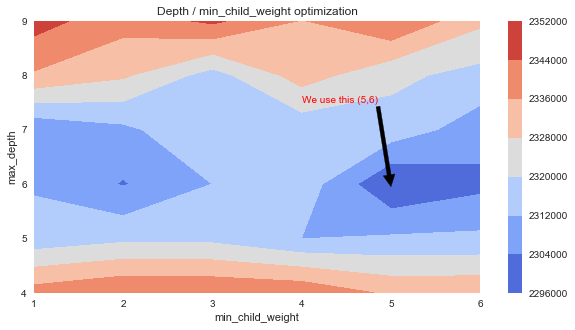

In [55]:
plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_params_cv_1['min_child_weight'], xgb_params_cv_1['max_depth'], scores_1, cmap='coolwarm')

plt.colorbar(cp)
plt.title('Depth / min_child_weight optimization')
plt.xlabel('min_child_weight')
plt.ylabel('max_depth')
plt.grid(True)

plt.annotate('We use this (5,6)', xy=(5., 5.95), xytext=(4, 7.5), arrowprops=dict(facecolor='black'), color='red')


plt.show()

### Step 3: Reducing gamma loss 

https://www.kaggle.com/c/santander-customer-satisfaction/discussion/20662#118487

In [56]:
xgb_params_cv_2 = {'gamma':[ 0.2 * i for i in range(0,6)]}

In [66]:
xgb_params_2 = {
                 'colsample_bytree': 0.5,
                 'eta': 0.1,
                 'eval_metric': 'rmse',
                 'objective': 'reg:linear',
                 'seed': 0,
                 'silent': 0,
                 'subsample': 0.5,
                 'max_depth' : 6,
                 'min_child_weight':5  
             }

In [67]:
optimzed_xgb_gamma = GridSearchCV(estimator=xgb.XGBRegressor(**xgb_params_2), param_grid=xgb_params_cv_2,
                                  scoring='mean_squared_error',cv = 5, n_jobs = -1)

In [68]:
%%time
optimzed_xgb_gamma.fit(train_X, train_y)

Wall time: 2min 48s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, eta=0.1, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=0, subsample=0.5),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'gamma': [0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [69]:
optimzed_xgb_gamma.grid_scores_

[mean: -5272927933423.76562, std: 642791685925.12915, params: {'gamma': 0.0},
 mean: -5272927933423.76562, std: 642791685925.12915, params: {'gamma': 0.2},
 mean: -5272927933423.76562, std: 642791685925.12915, params: {'gamma': 0.4},
 mean: -5272927933423.76562, std: 642791685925.12915, params: {'gamma': 0.6000000000000001},
 mean: -5272927933423.76562, std: 642791685925.12915, params: {'gamma': 0.8},
 mean: -5272927933423.76562, std: 642791685925.12915, params: {'gamma': 1.0}]

In [70]:
mse2rmse(optimzed_xgb_gamma.grid_scores_)

rmse: 2296285.6820142753 params: {'gamma': 0.0}
rmse: 2296285.6820142753 params: {'gamma': 0.2}
rmse: 2296285.6820142753 params: {'gamma': 0.4}
rmse: 2296285.6820142753 params: {'gamma': 0.6000000000000001}
rmse: 2296285.6820142753 params: {'gamma': 0.8}
rmse: 2296285.6820142753 params: {'gamma': 1.0}


Even after different set of gamma values, the error did no change much. So we will continue to use "gamma" = 0

### Step 4: Tuning subsample and colsample_bytree

In [62]:
xgb_params_cv_3 = {'subsample':[ 0.1 * i for i in range(5,10)],'colsample_bytree':[ 0.1 * i for i in range(5,10)] }

In [71]:
xgb_params_3 = {
                 'eta': 0.1,
                 'eval_metric': 'rmse',
                 'objective': 'reg:linear',
                 'seed': 0,
                 'silent': 0,
                 'max_depth' : 6,
                 'min_child_weight':5,
                 'gamma': 0
             }

In [72]:
optimzed_xgb_3 = GridSearchCV(estimator=xgb.XGBRegressor(**xgb_params_3), param_grid=xgb_params_cv_3,
                                  scoring='mean_squared_error',cv = 5, n_jobs = -1)

In [73]:
%%time
optimzed_xgb_3.fit(train_X, train_y)

Wall time: 13min 35s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=0, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'subsample': [0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9], 'colsample_bytree': [0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [74]:
optimzed_xgb_3.grid_scores_,optimzed_xgb_3.best_params_,optimzed_xgb_3.best_score_

([mean: -5272927933423.76562, std: 642791685925.12915, params: {'subsample': 0.5, 'colsample_bytree': 0.5},
  mean: -5267550381396.58105, std: 657410545698.19983, params: {'subsample': 0.6000000000000001, 'colsample_bytree': 0.5},
  mean: -5237609978727.98438, std: 613570856530.19910, params: {'subsample': 0.7000000000000001, 'colsample_bytree': 0.5},
  mean: -5199642593741.51465, std: 626135069816.50232, params: {'subsample': 0.8, 'colsample_bytree': 0.5},
  mean: -5245210351854.91504, std: 638594218199.51379, params: {'subsample': 0.9, 'colsample_bytree': 0.5},
  mean: -5296331485722.56348, std: 605432214734.26453, params: {'subsample': 0.5, 'colsample_bytree': 0.6000000000000001},
  mean: -5292985195308.33398, std: 660323643051.24512, params: {'subsample': 0.6000000000000001, 'colsample_bytree': 0.6000000000000001},
  mean: -5251061998320.16992, std: 656603177653.90540, params: {'subsample': 0.7000000000000001, 'colsample_bytree': 0.6000000000000001},
  mean: -5222316382243.92578, s

In [75]:
mse2rmse(optimzed_xgb_3.grid_scores_)

rmse: 2296285.6820142753 params: {'subsample': 0.5, 'colsample_bytree': 0.5}
rmse: 2295114.45932367 params: {'subsample': 0.6000000000000001, 'colsample_bytree': 0.5}
rmse: 2288582.5260907644 params: {'subsample': 0.7000000000000001, 'colsample_bytree': 0.5}
rmse: 2280272.4823453696 params: {'subsample': 0.8, 'colsample_bytree': 0.5}
rmse: 2290242.422071278 params: {'subsample': 0.9, 'colsample_bytree': 0.5}
rmse: 2301375.998337204 params: {'subsample': 0.5, 'colsample_bytree': 0.6000000000000001}
rmse: 2300648.8639747556 params: {'subsample': 0.6000000000000001, 'colsample_bytree': 0.6000000000000001}
rmse: 2291519.5827922067 params: {'subsample': 0.7000000000000001, 'colsample_bytree': 0.6000000000000001}
rmse: 2285238.8020169633 params: {'subsample': 0.8, 'colsample_bytree': 0.6000000000000001}
rmse: 2282374.6027276255 params: {'subsample': 0.9, 'colsample_bytree': 0.6000000000000001}
rmse: 2307938.998187053 params: {'subsample': 0.5, 'colsample_bytree': 0.7000000000000001}
rmse: 23

In [77]:
optimzed_xgb_3.best_score_, optimzed_xgb_3.best_params_

(-5199642593741.515, {'colsample_bytree': 0.5, 'subsample': 0.8})

In [76]:
print([{'rmse' : (abs(optimzed_xgb_3.best_score_)**0.5)}, optimzed_xgb_3.best_params_])

[{'rmse': 2280272.4823453696}, {'subsample': 0.8, 'colsample_bytree': 0.5}]


In [78]:
scores_3 = convert_grid_scores(optimzed_xgb_3.grid_scores_)

_, scores_3 = convert_grid_scores(optimzed_xgb_3.grid_scores_)

scores_3 = scores_3.reshape(5,5)
scores_3 = (abs(scores_3))**0.5

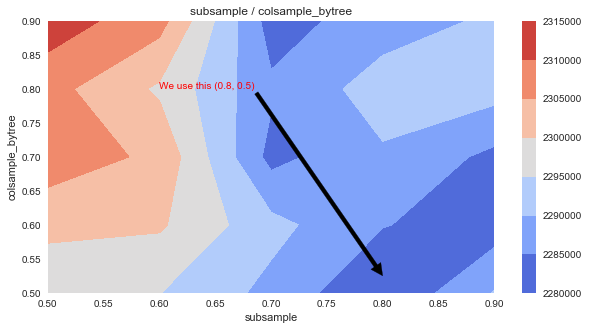

In [82]:
plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_params_cv_3['subsample'], xgb_params_cv_3['colsample_bytree'], scores_3, cmap='coolwarm')

plt.colorbar(cp)
plt.title('subsample / colsample_bytree')
plt.xlabel('subsample')
plt.ylabel('colsample_bytree')
plt.grid(True)

plt.annotate('We use this (0.8, 0.5)', xy=(0.8,0.525), xytext=(0.6, 0.8), arrowprops=dict(facecolor='black'), color='red')


plt.show()